### **Machine Learning Star Classification**
Classification of stars based on their spectral characteristics

**Authors:**
- *Stefano Quaggio 866504*
- *Stefano Andreotti 851596*
- *Alberto Varisco 866109*

**Classification models used:**
- <u>Neural Networks</u>
- <u>SVM</u>
- <u>K-Means Algorithm</u>

## <u>Initial Analysis</u>

In [24]:
# All libraries imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

#Diamo accesso al nostro google drive che conterrà il dataset che utilizzeremo in questo laboratorio
# from google.colab import drive

# drive.mount('/content/drive/')

In [25]:
full_df = pd.read_csv('../dataset/star_classification.csv')

full_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [26]:
full_df.info()
# Check number of missing values in columns
full_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

array([[<Axes: title={'center': 'obj_ID'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'delta'}>, <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'i'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'run_ID'}>,
        <Axes: title={'center': 'rerun_ID'}>,
        <Axes: title={'center': 'cam_col'}>,
        <Axes: title={'center': 'field_ID'}>],
       [<Axes: title={'center': 'spec_obj_ID'}>,
        <Axes: title={'center': 'redshift'}>,
        <Axes: title={'center': 'plate'}>,
        <Axes: title={'center': 'MJD'}>],
       [<Axes: title={'center': 'fiber_ID'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

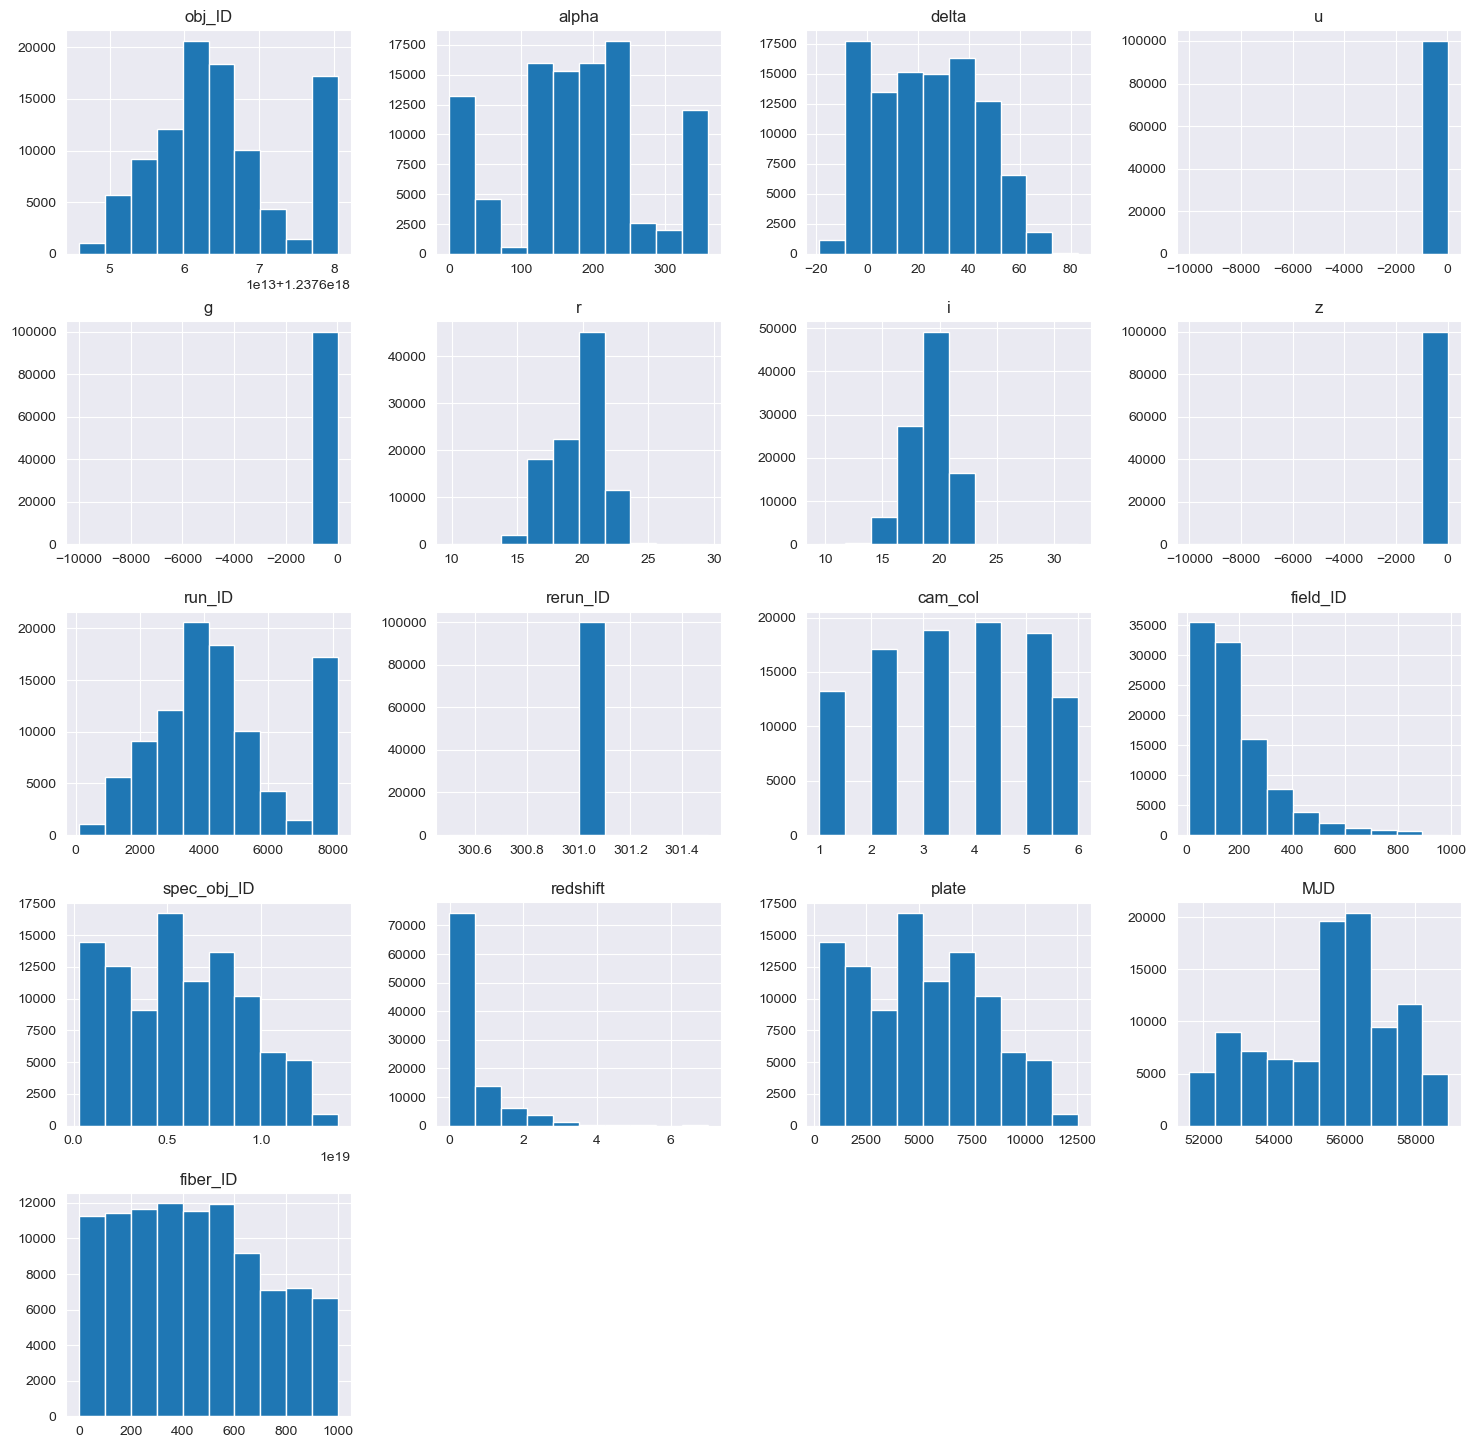

In [27]:
full_df.hist(figsize=(18,18))

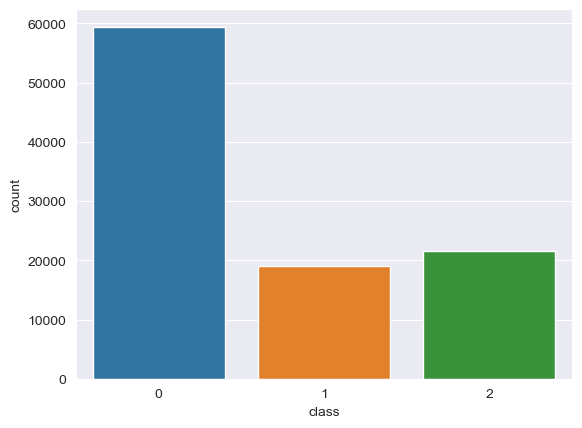

In [28]:
# Initialize LabelEncoder object
label_encoder = LabelEncoder()

# Apply LabelEncoder on 'class' column (target) -> 0 = Galaxy, 1 = Quasar, 2 = Star
full_df['class'] = label_encoder.fit_transform(full_df['class'])
# create dict with { label: value } (funziona solo quando viene eseguito dall'inizio se no diventa { value: value })
#label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# per non dover rieseguire tutto il codice dall'inizio
label_mapping = { 'Galaxy': 0, 'Quasar': 1, 'Star': 2 }

#Check distribution of target variable
sns.countplot(x = full_df['class'])
plt.show()

<Axes: >

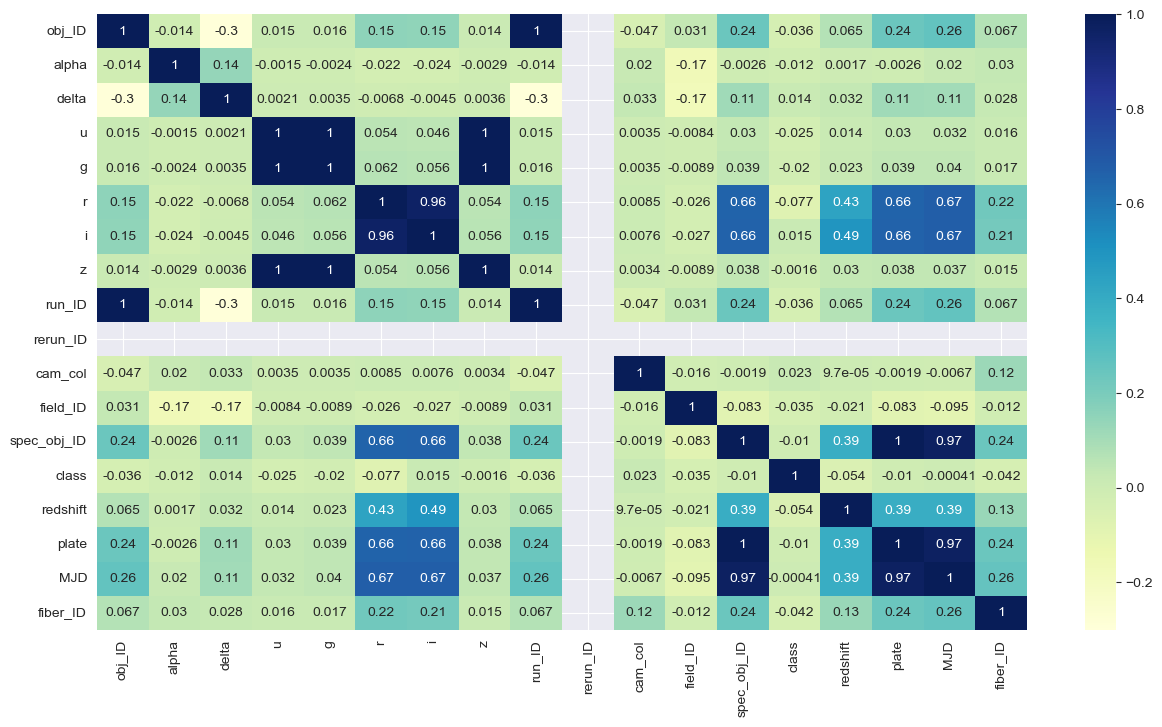

In [29]:
# Check correlation between features
plt.figure(figsize=(15,8))
sns.heatmap(full_df.corr(), annot=True, cmap='YlGnBu')

In [30]:
# Remove 'rerun_ID' column as it has only one value and is not useful for classification
full_df.drop(['rerun_ID'], axis=1, inplace=True)

# Split dataset into train and test sets
x = full_df.drop(['class'], axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


## Rete neurale

In [31]:
# Feature scaling (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-1.56162779e+00, -1.56741370e-01,  2.16401343e+00, ...,
         6.66340764e-01,  6.36779188e-01,  6.79915880e-01],
       [-1.13893879e+00,  2.66783749e-01,  1.70359490e+00, ...,
         1.03748792e+00,  1.42009271e+00,  5.55005268e-01],
       [-2.59339935e-01,  4.85489466e-01, -6.50567531e-01, ...,
        -1.15691542e+00, -9.72383225e-01, -9.14531351e-01],
       ...,
       [ 1.64516947e+00, -1.60156416e+00, -3.79927753e-01, ...,
         5.08851382e-04,  1.35745783e-01,  7.82783444e-01],
       [ 1.01520874e+00, -1.29708378e+00, -2.90341913e-01, ...,
        -6.59233135e-01, -4.23290387e-01,  2.90488676e-01],
       [-3.25949652e-01, -1.07379297e-02,  9.30882113e-01, ...,
         1.09804885e+00,  1.06323761e+00,  3.97030081e-01]])

In [32]:
# Convert target variable to categorical, as it is a multi-class classification problem
y_train_neural = keras.utils.to_categorical(y_train)
y_test_neural = keras.utils.to_categorical(y_test)
print(X_test.shape, y_test_neural.shape)

print(y_train_neural)

(20000, 16) (20000, 3)
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


Epoch 1/20
800/800 [==============================] - 2s 1ms/step - loss: 0.3876 - accuracy: 0.8540 - val_loss: 0.1910 - val_accuracy: 0.9375
Epoch 2/20
800/800 [==============================] - 1s 1ms/step - loss: 0.2002 - accuracy: 0.9457 - val_loss: 0.1522 - val_accuracy: 0.9546
Epoch 3/20
800/800 [==============================] - 1s 1ms/step - loss: 0.1630 - accuracy: 0.9542 - val_loss: 0.1383 - val_accuracy: 0.9579
Epoch 4/20
800/800 [==============================] - 1s 1ms/step - loss: 0.1414 - accuracy: 0.9578 - val_loss: 0.1337 - val_accuracy: 0.9602
Epoch 5/20
800/800 [==============================] - 1s 1ms/step - loss: 0.1303 - accuracy: 0.9600 - val_loss: 0.1248 - val_accuracy: 0.9632
Epoch 6/20
800/800 [==============================] - 1s 1ms/step - loss: 0.1250 - accuracy: 0.9624 - val_loss: 0.1213 - val_accuracy: 0.9638
Epoch 7/20
800/800 [==============================] - 1s 1ms/step - loss: 0.1208 - accuracy: 0.9636 - val_loss: 0.1176 - val_accuracy: 0.9653
Epoch 

C:\Users\stefa\AppData\Local\Temp\ipykernel_18760\2023690714.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(222)


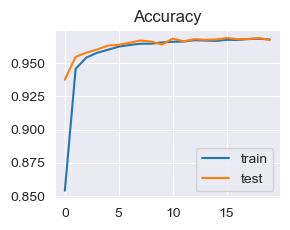

In [33]:
input_features = X_train.shape[1]

model=Sequential()
model.add(Dense(32, input_dim=input_features, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train_neural, epochs=20, batch_size=100, verbose=1, validation_data=(X_test, y_test_neural))

# Evaluate the model on the test set
_, train_acc = model.evaluate(X_train, y_train_neural, verbose=0)
_, test_acc = model.evaluate(X_test, y_test_neural, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(222)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes=np.argmax(yhat_probs,axis=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

y_test_unidimension = [0 if val[0] else 1 if val[1] else 2 for val in y_test_neural]
    
print(classification_report(y_test_unidimension, yhat_classes, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

      Galaxy       0.97      0.98      0.97     11817
      Quasar       0.96      0.92      0.94      3849
        Star       0.97      0.98      0.98      4334

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000


## SVM

In [35]:
from sklearn import svm

# Crea il classificatore SVM
# C = 1 default provato C=100 cambia pochissimo non vale la pena
sv = svm.SVC(kernel='linear', C=1, probability=True)

sv.fit(X_train, y_train)
y_pred = sv.predict(X_test)

# calcolo dell'accuratezza
# label_mapping dict: Galaxy = 0, Quasar = 1, Star = 2
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza: {accuracy}\n\n")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))
print("\n\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuratezza: 0.96175


              precision    recall  f1-score   support

      Galaxy       0.96      0.97      0.97     11817
      Quasar       0.95      0.89      0.92      3849
        Star       0.96      1.00      0.98      4334

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.96     20000
weighted avg       0.96      0.96      0.96     20000



Confusion matrix:
 [[11486   163   168]
 [  432  3415     2]
 [    0     0  4334]]


In [36]:
# from sklearn.metrics import roc_curve, roc_auc_score
# 
# y_pred_prob = sv.predict_proba(X_test)[:, 1]
# 
# # Calcola la curva ROC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# 
# # Calcola l'AUC della curva ROC
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# 
# # Disegna la curva ROC
# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

ValueError: multiclass format is not supported

## Decision Tree


In [ ]:
# Decision Tree
model = DecisionTreeClassifier(random_state = 30)
model.fit(X_train, y_train)
y_pred3 = model.predict(X_test)

dtree_score = recall_score(y_test, y_pred3, average='weighted')
print(dtree_score)

In [ ]:
# Stampa albero
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(model, filled=True, ax=ax)
plt.plot()
# Salva l'albero
# plt.savefig("quattr.svg", format="svg")

In [ ]:
# Predizione per nuovo modello
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuratezza:", cm.diagonal().sum() / cm.sum())

In [ ]:
path = model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
# Valori di complessità = [0.001, 0.01, 0.1, 1, 10, 100]
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

In [ ]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Numero di nodi")
ax[0].set_title("Numero nodi vs Alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Profondità albero")
ax[1].set_title("Profondità albero vs Alpha")
fig.tight_layout()